In [36]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import block_update
import bouguer
import prisms
import rfgen
import utilities

import importlib
importlib.reload(block_update)
importlib.reload(bouguer)
importlib.reload(rfgen)
importlib.reload(prisms)
importlib.reload(utilities)

from block_update import *
from bouguer import *
from rfgen import *
from prisms import *
from utilities import *

from utilities import calc_terrain_effect

### Load BedMachine

Your dataset needs to have x and y coordinates, and bed, surface, thickness, and inv_msk data variables. Additionally, your dataset needs to have an attribute called *res* that is the spacing between your coordinates. To assign this attribute you can use:

ds.assign_attrs({'res' : 2000})

In [3]:
# open BedMachine
bm = xr.open_dataset('cryo_share/BedMachineAntarctica-v3.nc')

# define area around Larsen Ice Shelf
xmin = -2.5e6
xmax = -1.9e6
ymin = 1.0e6
ymax = 1.3e6

# trim data to area around ice shelf
ds = bm.sel (x=slice(xmin, xmax), y=slice(ymax, ymin))

# coarsen and view data
ds = ds.coarsen(x=8, y=8, boundary='trim', coord_func='median').median()
ds

<xarray.Dataset> Size: 587kB
Dimensions:    (y: 75, x: 150)
Coordinates:
  * x          (x) float64 1kB -2.498e+06 -2.494e+06 ... -1.906e+06 -1.902e+06
  * y          (y) float64 600B 1.298e+06 1.294e+06 ... 1.006e+06 1.002e+06
Data variables:
    mapping    |S1 1B b''
    mask       (y, x) float64 90kB 0.0 0.0 0.0 0.0 0.0 ... 2.0 3.0 3.0 3.0 3.0
    firn       (y, x) float32 45kB 0.0 0.0 0.0 0.0 ... 8.106 9.234 8.634 8.055
    surface    (y, x) float32 45kB 0.0 0.0 0.0 0.0 ... 4.593 6.092 18.03 27.03
    thickness  (y, x) float32 45kB 0.0 0.0 0.0 0.0 ... 37.08 56.24 167.7 251.8
    bed        (y, x) float32 45kB -170.5 -623.9 -753.5 ... -260.3 -302.4 -292.8
    errbed     (y, x) float32 45kB 10.0 10.0 10.0 10.0 ... 33.0 34.0 33.0 33.0
    source     (y, x) float64 90kB 3.0 1.0 1.0 3.0 3.0 ... 3.0 3.0 1.0 1.0 3.0
    dataid     (y, x) float64 90kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    geoid      (y, x) float64 90kB 19.0 19.0 19.0 19.0 19.0 ... 7.0 7.0 6.0 6.0
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [4]:
# assign inv_mask variable
ds['inv_msk'] = xr.where(ds.mask == 3, True, False)

# assign res variable
ds = ds.assign_attrs({'res' : 2000})
print(ds.res)

2000


### Load gravity dataset

Your gravity dataset needs x, y, height, faa, inv_msk, and inv_pad. The inv_pad is a padding of your inversion mask. This should be about 8-12 km.

In [5]:
import os
from tqdm.auto import tqdm

# get number of OIB folders for tqdm
num_folders = 0
for folder in os.scandir(Path('cryo_share/OIB_Sander')):
    num_folders += 1

# iterate through folders and ingest data
tables = []
for folder in tqdm(os.scandir(Path('cryo_share/OIB_Sander')), total=num_folders):
    for item in os.scandir(folder.path):
        if item.name.endswith('.txt'):
            tmp = pd.read_table(item.path, header=69, sep='\s+')
            header = tmp.columns[1:]
            tmp = tmp.drop(columns=['FLTENVIRO'])
            tmp.columns = header
            tables.append(tmp)

grav = pd.concat(tables, axis=0)

# trim to Larsen Ice Shelf with 10 km padding
grav = grav[['LAT', 'LONG', 'PSX', 'PSY', 'FAG070', 'FLTENVIRO', 'WGSHGT']]
grav.columns = ['lat', 'lon', 'x', 'y', 'faa', 'flag', 'height']
grav = grav[grav.flag == 0]
grav = grav.drop(columns=['flag']).reset_index(drop=True)

xmin_trim = xmin + 10e3
xmax_trim = xmax - 10e3
ymin_trim = ymin + 10e3
ymax_trim = ymax - 10e3

mask_trim = (grav.x < xmax_trim) & (grav.x > xmin_trim) & (grav.y < ymax_trim) & (grav.y > ymin_trim)

grav = grav.loc[mask_trim , :]

grav = grav.reset_index(drop=True)
grav

  0%|          | 0/155 [00:00<?, ?it/s]

,lat,lon,x,y,faa,height
0,-65.293939,-61.746279,-2400409.27,1289987.36,22.18,739.00
1,-65.294420,-61.746532,-2400366.91,1289950.93,22.13,739.80
2,-65.294900,-61.746783,-2400324.48,1289914.54,22.07,740.69
3,-65.295381,-61.747033,-2400281.95,1289878.22,22.02,741.63
4,-65.295862,-61.747279,-2400239.30,1289842.00,21.97,742.58
...,...,...,...,...,...,...
375632,-68.271775,-64.407740,-2154065.04,1031697.26,-9.25,519.17
375633,-68.272394,-64.407434,-2153996.74,1031678.72,-9.25,519.31
375634,-68.273013,-64.407126,-2153928.43,1031660.21,-9.24,519.38
375635,-68.273631,-64.406818,-2153860.11,1031641.75,-9.23,519.38


In [6]:
grav = grav[::10]

In [32]:
def upward_continue(grav, height, ds, maxdist):
    xx, yy = np.meshgrid(ds.x, ds.y)
    pred_coords = (xx, yy, np.full(xx.shape, height))
    grav_tmp = grav[grav.height < height]
    equivalent_sources = hm.EquivalentSourcesGB(damping=1, depth=3000, window_size=20e3)
    coordinates = (grav_tmp.x.values, grav_tmp.y.values, grav_tmp.height.values)
    equivalent_sources.fit(coordinates, grav_tmp.faa.values)
    leveled = equivalent_sources.predict(pred_coords)

    dist_msk = vd.distance_mask(coordinates[:2], maxdist, pred_coords[:2])
    masked = np.where(dist_msk, leveled, np.nan)

    return masked

In [8]:
height = 5000
grav_uc = upward_continue(grav, height, ds, 5000)
xx, yy = np.meshgrid(ds.x, ds.y)

grav_leveled = pd.DataFrame({
    'x': xx.flatten(),
    'y': yy.flatten(),
    'faa': grav_uc.flatten(),
    'height': np.full(grav_uc.flatten().size, height),
    'inv_msk': ds.inv_msk.values.flatten()
})

terrain_gz = calc_terrain_effect(ds, grav_leveled)
grav_leveled['bouguer'] = grav_leveled['faa'] - terrain_gz

In [9]:
xx, yy = np.meshgrid(ds.x, ds.y)
inv_pad = vd.distance_mask(
    data_coordinates = (xx[ds.inv_msk==True], yy[ds.inv_msk==True]),
    coordinates = (grav_leveled.x, grav_leveled.y),
    maxdist = 10e3
)

grav_leveled['inv_pad'] = inv_pad
grav_leveled = grav_leveled.dropna()
grav_leveled['inv_msk'] = grav_leveled['inv_msk'].replace(0, False).replace(1, True)
grav_leveled = grav_leveled[(grav_leveled.x >= int(min(ds.x))) & (grav_leveled.x <= int(max(ds.x))) &
        (grav_leveled.y >= int(min(ds.y))) & (grav_leveled.y <= int(max(ds.y)))]

In [11]:
grav = grav_leveled
grav

,x,y,faa,height,inv_msk,bouguer,inv_pad
170,-2418250.0,1294250.0,45.648637,5000,False,20.416401,True
173,-2406250.0,1294250.0,31.745570,5000,False,29.657970,False
174,-2402250.0,1294250.0,27.809643,5000,False,35.429998,False
175,-2398250.0,1294250.0,25.080607,5000,False,40.329539,False
180,-2378250.0,1294250.0,19.044935,5000,False,46.554784,False
...,...,...,...,...,...,...,...
11081,-1974250.0,1006250.0,42.976100,5000,False,-7.109600,False
11082,-1970250.0,1006250.0,36.096324,5000,False,-9.495436,False
11091,-1934250.0,1006250.0,16.411176,5000,False,2.197849,False
11092,-1930250.0,1006250.0,15.126961,5000,False,2.332495,False


### Make a target terrain effect using SGS and filter

* The *nte_correction_sgs* function makes an SGS realization of the Bouguer disturbance for the given density
* The *filter_boug* function filters the Bouguer disturbance with the given cutoff distance. You can experiment with this parameter to make a target terrain effect that looks like a continuous field. The higher this value, the smoother the Bouguer disturbance will become
* The *sgs_filt* function can be used to do both of these things

In [21]:
target = nte_correction_sgs(ds, grav, density=2670)
boug_filt = filter_boug(ds, grav, target, cutoff=15e3, pad=0)
new_target = grav.faa.values - boug_filt

In [22]:
# put gravity into grid for visualization purposes
faa_grid, target_grid, boug_filt_grid = xy_into_grid(
    ds, 
    coords = (grav.x.values, grav.y.values), 
    values = (grav.faa.values, target, boug_filt)
)

In [23]:
boug_sgs = faa_grid - target_grid
new_target_grid = faa_grid - boug_filt_grid

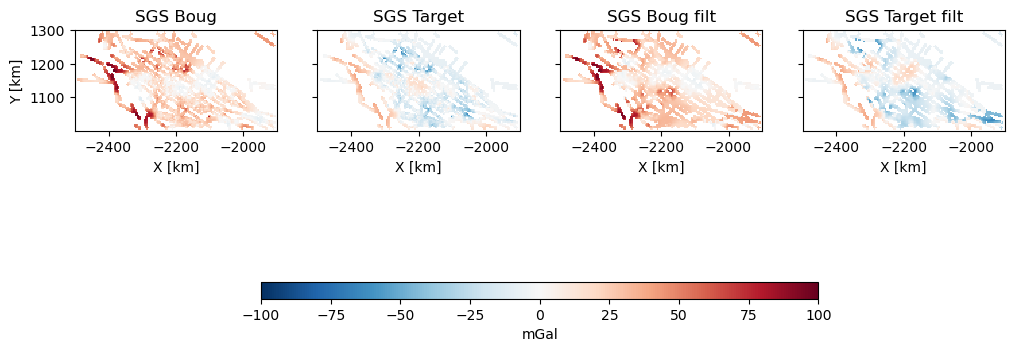

In [24]:
xkm = ds.x/1000
ykm = ds.y/1000

grav_vmin = -100
grav_vmax = 100

fig = plt.figure(figsize=(12,5))

gridspec = GridSpec(2, 4, height_ratios=[1, 0.05])

grids = [boug_sgs, target_grid, boug_filt_grid, new_target_grid]
titles = ['SGS Boug', 'SGS Target', 'SGS Boug filt', 'SGS Target filt']

axs = []
for i, (grid, title) in enumerate(zip(grids, titles)):
    ax = fig.add_subplot(gridspec[0,i])
    axs.append(ax)
    im = ax.pcolormesh(xkm, ykm, grid, vmin=grav_vmin, vmax=grav_vmax, cmap='RdBu_r')
    ax.axis('scaled')
    ax.set_title(title)
    ax.set_xlabel('X [km]')

axs[0].set_ylabel('Y [km]')

for ax in axs[1:]:
    ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:])
cax = fig.add_subplot(gs2[20:80])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

### Make a target with *sgs_filt* for inversion and get gravity inside the inv_pad

In [25]:
%%time

target = sgs_filt(ds, grav, 2670, 12e3)
target = target[grav.inv_pad==True]

# trim gravity data
grav_mskd = grav[grav.inv_pad==True]

CPU times: total: 4min 18s
Wall time: 45.5 s


### Make random field for initial condition

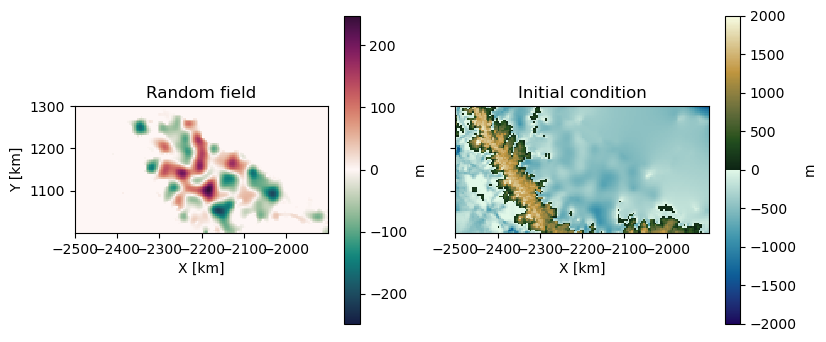

In [26]:
# make arrays for random field generation
range_max = [50e3, 50e3]
range_min = [30e3, 30e3]
high_step = 300
nug_max = 0.0
eps = 3e-4

rfgen = RFGen(ds, range_max, range_min, high_step, nug_max, eps, 'Gaussian')
field = rfgen.generate_field(condition=True)

x0 = ds.bed.data + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

vmax = np.max(np.abs(field))

fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, field, vmax=vmax, vmin=-vmax, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('Random field')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, label='m')

topo_cm = get_topo_cm()

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, x0, vmax=2000, vmin=-2000, cmap=topo_cm)
ax.axis('scaled')
ax.set_title('Initial condition')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, label='m')

plt.show()

### Make prism generator and observation coordinates

In [27]:
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}
pgen = PrismGen(density_dict)

pred_coords = (grav_mskd.x.values, grav_mskd.y.values, grav_mskd.height.values)

In [28]:
pred_coords[0].shape, target.shape

((3349,), (3349,))

### Set parameters for inversion and run the inversion

* You will want to tune the block parameter sequence to make the inversion
* The sigma gravity uncertainty comes from crossover errors in my data. You can use this or change it if you have information about the uncertainty of your gravity data. This will change how likely the MCMC is to accept changes that make the error worse.
* The stopping criterion stops the inversion once the RMSE reaches a certain point. You will want to experiment to find a value that your inversion can reach in a reasonable amount of time. Note that you don't really want to push this to find the lowest value that you can reach. The inversion will overfit the data as it continues.

In [37]:
# block size, range, amplitude, iterations
sequence = [
    [21, 20, 60, 1000],
    [15, 20, 40, 1000],
    [9, 5, 40, 5000],
    [5, 5, 40, 40000]
]

# gravity uncertainty
sigma = 1.6

# RMSE stopping condition
stop = 1

# get random number generator
rng = np.random.default_rng(seed=0)

# run chain sequence and time it
tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, pgen, rng, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.040 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.020 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.010 RMSE/sec


  0%|          | 0/40000 [00:00<?, ?it/s]

chain 3 efficiency: -0.004 RMSE/sec
0 finished
total time: 575.6


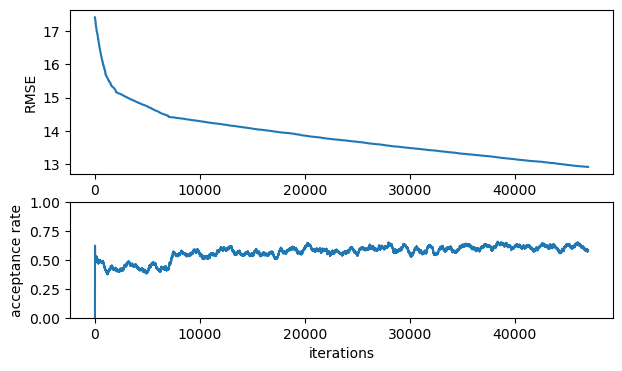

In [51]:
from diagnostics import run_acceptance_rate

rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

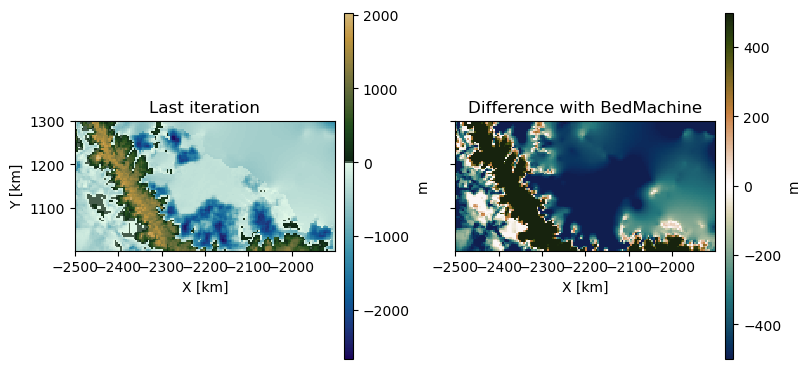

In [53]:
import cmocean
from utilities import get_topo_cm

bed = result['bed_cache']

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(topo_cmap, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

### Let's look at the gravity residual at the end

In [54]:
target_grid, grav_result_grid = xy_into_grid(ds, (pred_coords[0], pred_coords[1]), 
                                             (target, result['grav_cache']))

residual_grid = target_grid - grav_result_grid

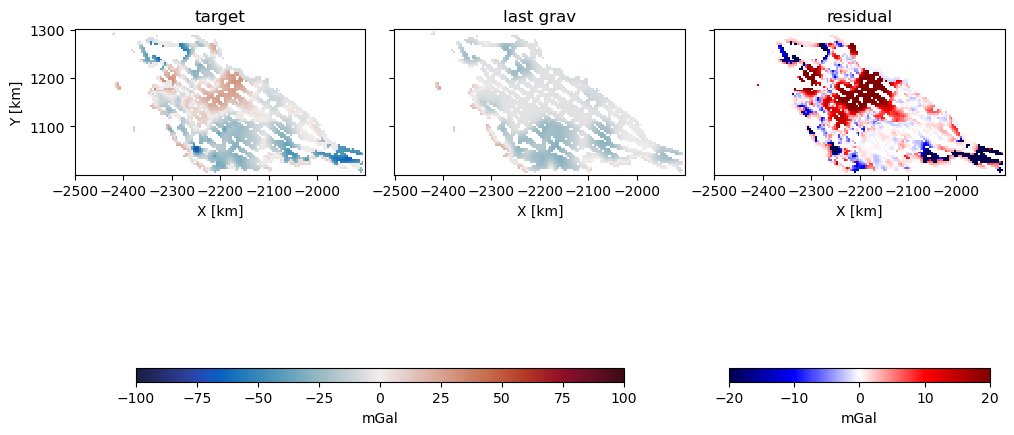

In [55]:
#fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

fig = plt.figure(figsize=(12,6.5))
gridspec = GridSpec(2, 3, height_ratios=[1, 0.03], wspace=0.1)

ax1 = fig.add_subplot(gridspec[0,0])
ax2 = fig.add_subplot(gridspec[0,1])
ax3 = fig.add_subplot(gridspec[0,2])

ax = ax1
im = ax.pcolormesh(xkm, ykm, target_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('target')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = ax2
im = ax.pcolormesh(xkm, ykm, grav_result_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('last grav')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:2])
cax = fig.add_subplot(gs2[10:90])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')

ax = ax3
im = ax.pcolormesh(xkm, ykm, residual_grid, vmin=-20, vmax=20, cmap='seismic')
ax.axis('scaled')
ax.set_title('residual')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs3 = GridSpecFromSubplotSpec(1, 100, gridspec[1,2])
cax = fig.add_subplot(gs3[5:95])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

### Filter the final bed iteration

The inversion process can create some edge artifacts because of the blocks. Let's use a lowpass Gaussian filter to smooth it out a little. You can change the cutoff to change how much smoothing there is.

In [56]:
bed_filt = lowpass_filter_domain(ds, ds.bed, np.ones(ds.bed.shape), cutoff=5e3, pad=0)
bed_filt = bed_filt.reshape(ds.bed.shape)
bed_high = ds.bed-bed_filt

In [57]:
vmin_topo = np.min(ds.bed); vmax_topo = np.max(ds.bed)

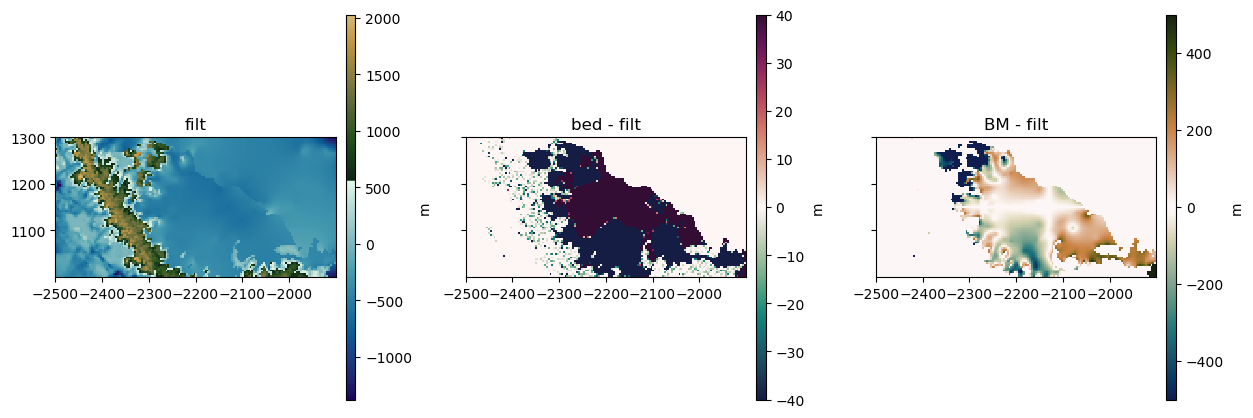

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed-bed_filt, vmin=-40, vmax=40, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('bed - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('BM - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')
plt.show()

### We can look at the high frequency and see that it has linear edges in it

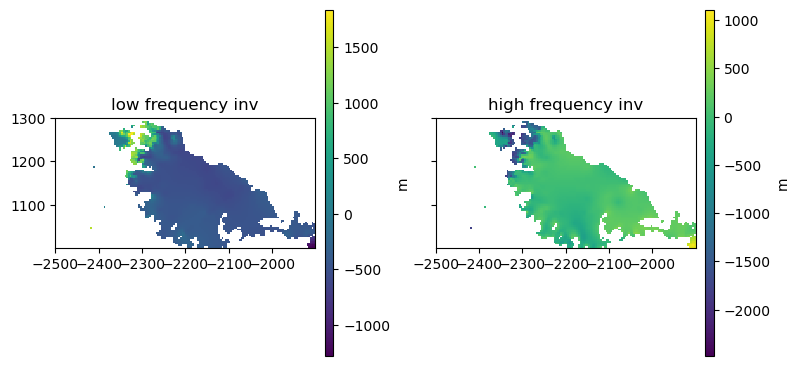

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

ax = axs[0]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_filt, np.nan))
ax.axis('scaled')
ax.set_title('low frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_high, np.nan))
ax.axis('scaled')
ax.set_title('high frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

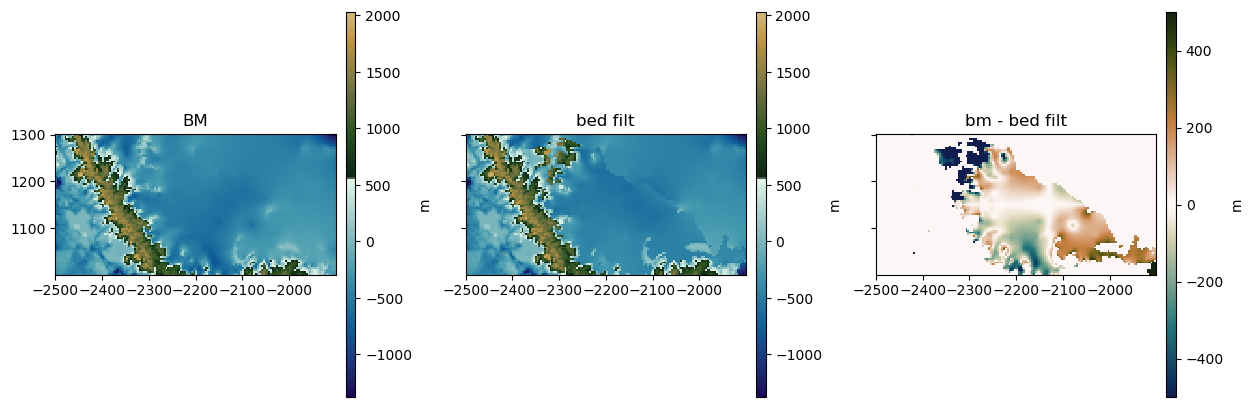

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, ds.bed, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('BM')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('bed filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('bm - bed filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

## Conditioning on boundary of inversion domain

* These are weights that will be applied to updates to prevent dramatic changes on the inversion domain boundary.
* These functions can be used to make weights using a logistic function
* You can test out different parameters to the logistic function to make different weights
* Having low weights near the conditioning data will make it take longer to lower the RMSE

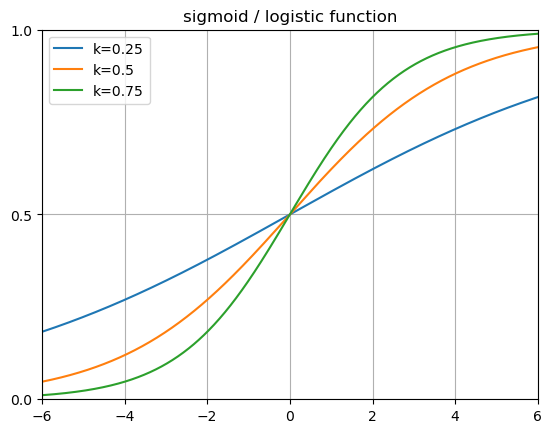

In [65]:
import matplotlib.ticker as plticker

tmp = np.linspace(-6, 6, 1000)

fig, ax = plt.subplots()

for k in [0.25, 0.5, 0.75]:
    ax.plot(tmp, logistic(tmp, 1, 0, k), label=f'k={str(k)}')
    
intervals = 0.5
loc = plticker.MultipleLocator(base=intervals)
ax.yaxis.set_major_locator(loc)
intervals = 2
loc = plticker.MultipleLocator(base=intervals)
ax.xaxis.set_major_locator(loc)
ax.grid(which='major', axis='both', linestyle='-')
ax.set_ylim(0, 1.0)
ax.set_xlim(-6, 6)
ax.set_title('sigmoid / logistic function')
ax.legend()
plt.show()

### Test out parameters to apply to the rescaled distance from conditioning data

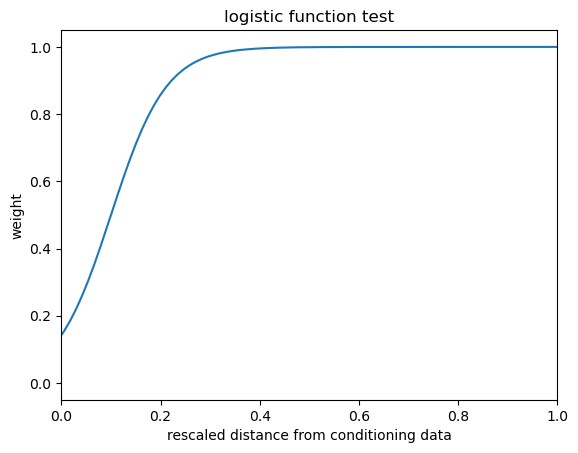

In [66]:
plt.plot(tmp, logistic(tmp, 1, 0.1, 18))
plt.xlim(0, 1)
plt.xlabel('rescaled distance from conditioning data')
plt.ylabel('weight')
plt.title('logistic function test')
plt.show()

In [67]:
xx, yy = np.meshgrid(ds.x, ds.y)
min_dist_l2 = min_dist_simple(ds.inv_msk.values, xx, yy)

dist_scale = rescale(min_dist_l2)
#dist_logi = logistic(dist_scale, 1, 0.3, 12)
dist_logi = logistic(dist_scale, 1, 0.05, 18)
dist_logi = np.where(ds.inv_msk==False, 0, dist_logi)

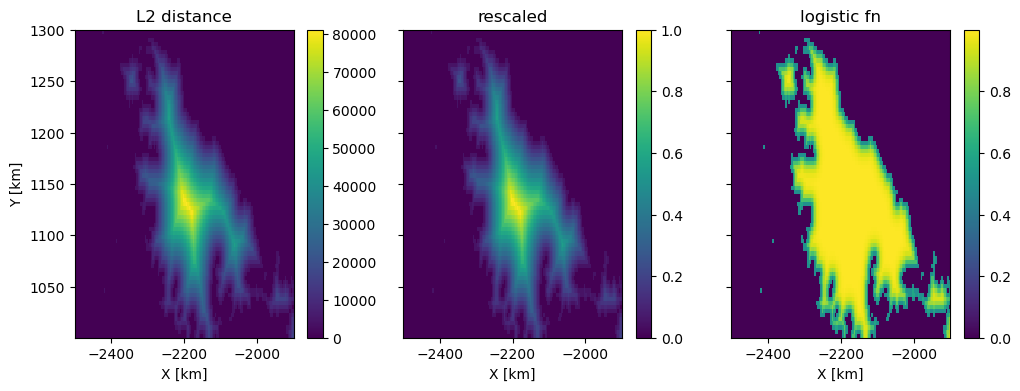

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, min_dist_l2)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('L2 distance')
plt.colorbar(im, ax=ax)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, dist_scale)
ax.set_xlabel('X [km]')
ax.set_title('rescaled')
plt.colorbar(im, ax=ax)

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, dist_logi)
ax.set_xlabel('X [km]')
ax.set_title('logistic fn')
plt.colorbar(im, ax=ax)

plt.show()

### Run inversion with conditioning weights

In [69]:
x0 = ds.bed.data + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

rng = np.random.default_rng(seed=0)

tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, pgen, rng, dist_logi, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.038 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.017 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.009 RMSE/sec


  0%|          | 0/40000 [00:00<?, ?it/s]

chain 3 efficiency: -0.003 RMSE/sec
0 finished
total time: 609.5


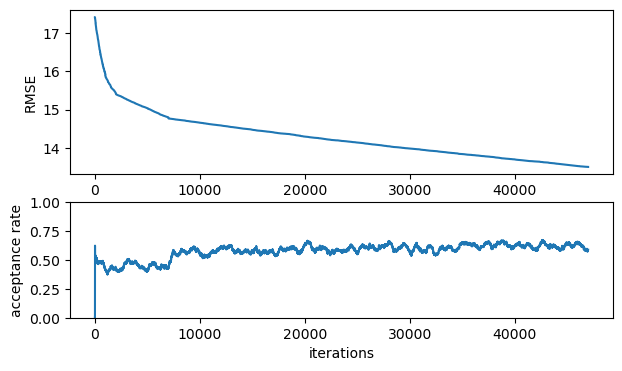

In [70]:
rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

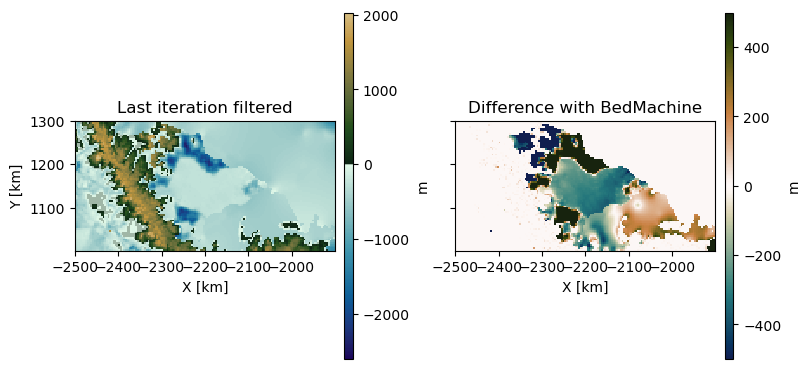

In [71]:
bed = result['bed_cache']

bed_filt = lowpass_filter_domain(ds, bed, np.ones(bed.shape), cutoff=5e3, pad=0)
bed_filt = bed_filt.reshape(bed.shape)

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(topo_cmap, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration filtered')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()